In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
import matplotlib.pyplot as plt
import numpy as np
import pylamp.utils.functions as fn
from pylamp.loss.losses import BCELoss, CrossEntropyLoss
from pylamp.neural.sequential import Sequential
from pylamp.neural.layers import Linear, Conv1D, MaxPool1D, Upsampling1D
from pylamp.optim.optimizer import Optim
from pylamp.neural.activations import TanH, Sigmoid
from pylamp.optim.optimizer import SGD
from pylamp.utils.usps import load_usps
from pylamp.utils.plotter import Display

## Loading Data

In [170]:
import tensorflow as tf

uspsdatatrain = "./data/USPS/USPS_train.txt"
uspsdatatest = "./data/USPS/USPS_test.txt"
X_train, y_train = load_usps(uspsdatatrain)
X_test, y_test = load_usps(uspsdatatest)

## Normalize value between 0 and 1 (targets for BCE)

In [171]:
X_train, X_test = fn.normalize_data(X_train, X_test, minmax=True)

## Autoencoder on USPS data

• Encodage : Linear(256,100) → TanH() → Linear(100,10) → TanH()

• Décodage : Linear(10,100) → TanH() → Linear(100,256) → Sigmoide()

### One big Sequential

In [215]:
autoencoder_linear = Sequential()
encoder_linear = Sequential()
decoder_linear = Sequential()

encoder_linear.add_module(Linear(256,100))
encoder_linear.add_module(TanH())
encoder_linear.add_module(Linear(100,10))
encoder_linear.add_module(TanH())
decoder_linear.add_module(Linear(10,100))
decoder_linear.add_module(TanH())
decoder_linear.add_module(Linear(100,256))
decoder_linear.add_module(Sigmoid())

autoencoder_linear.add_module(encoder_linear)
autoencoder_linear.add_module(decoder_linear)

loss = BCELoss()
optimizer_autoencoder = Optim(autoencoder_linear,loss,1e-3)
autoencoder_losses = SGD(optimizer_autoencoder,X_train, X_train, batch_size=64,epochs=250,verbose=True)

Epoch 1/250, Average Loss: 0.6458218014394007
Epoch 26/250, Average Loss: 0.3942847578003328
Epoch 51/250, Average Loss: 0.3515902999353212
Epoch 76/250, Average Loss: 0.33041028421023383
Epoch 101/250, Average Loss: 0.3146869298518217
Epoch 126/250, Average Loss: 0.3016141458412238
Epoch 151/250, Average Loss: 0.2922571041847065
Epoch 176/250, Average Loss: 0.28560097078014823
Epoch 201/250, Average Loss: 0.2805880997204323
Epoch 226/250, Average Loss: 0.2760442590108426
Training finished.


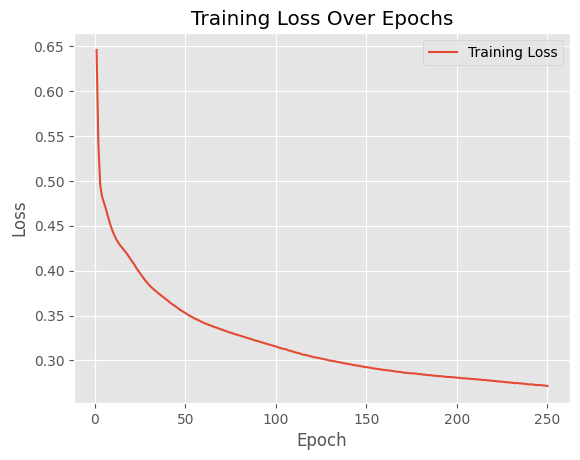

In [217]:
np.save("temp/autoencoder_linear_losses",autoencoder_losses)
Display().plot_loss(autoencoder_losses)

<Figure size 1000x500 with 0 Axes>

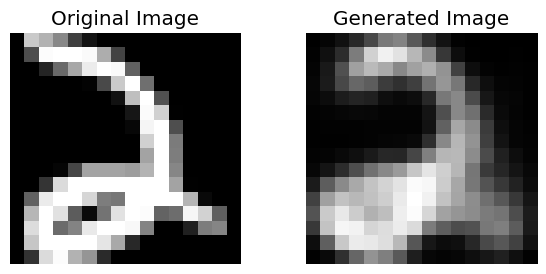

In [218]:
Display().plot_reconstruction(autoencoder_linear, X_test, y_test, n=1)

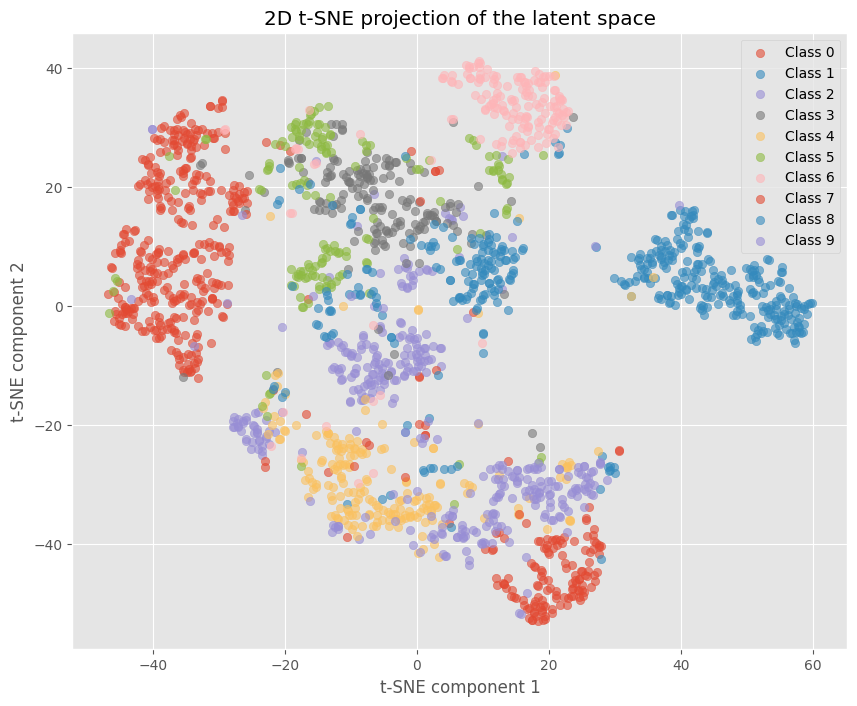

In [223]:
latent_space_lin = Display().plot_latent_space(X_test, y_test, encoder_linear, expand_dims=False)

### Autoencoder with conv

In [172]:
# Define the autoencoder
autoencoder_conv = Sequential()
encoder_conv = Sequential()
decoder_conv = Sequential()
# Define the encoder
encoder_conv.add_module(Conv1D(kernel_size=3, in_channels=1, out_channels=32, strides=1, padding='same'))
encoder_conv.add_module(MaxPool1D(kernel_size=2, strides=2))
encoder_conv.add_module(TanH())
encoder_conv.add_module(Conv1D(kernel_size=3, in_channels=32, out_channels=16, strides=1, padding='same'))
encoder_conv.add_module(MaxPool1D(kernel_size=2, strides=2))
encoder_conv.add_module(TanH())
# Define the decoder
decoder_conv.add_module(Upsampling1D(size=2))
decoder_conv.add_module(Conv1D(kernel_size=3, in_channels=16, out_channels=32, strides=1, padding='same'))
decoder_conv.add_module(TanH())
decoder_conv.add_module(Upsampling1D(size=2))
decoder_conv.add_module(Conv1D(kernel_size=3, in_channels=32, out_channels=1, strides=1, padding='same'))
decoder_conv.add_module(Sigmoid())
# Add the encoder and decoder to the autoencoder
autoencoder_conv.add_module(encoder_conv)
autoencoder_conv.add_module(decoder_conv)

loss = BCELoss()
optimizer_autoencoder_conv = Optim(autoencoder_conv,loss,1e-3)
autoencoder_losses_conv = SGD(optimizer_autoencoder_conv, X_train, X_train, batch_size=64, epochs=20, add_channel_x=True, add_channel_y=True, verbose=True)

Epoch 1/20, Average Loss: 0.5563952502938249
Epoch 3/20, Average Loss: 0.45446224581601313
Epoch 5/20, Average Loss: 0.38232903739726776
Epoch 7/20, Average Loss: 0.34133875178558104
Epoch 9/20, Average Loss: 0.3163759950485713
Epoch 11/20, Average Loss: 0.2979058444844086
Epoch 13/20, Average Loss: 0.2832038126556099
Epoch 15/20, Average Loss: 0.27156368666264374
Epoch 17/20, Average Loss: 0.26231614493367994
Epoch 19/20, Average Loss: 0.2552191123777001
Training finished.


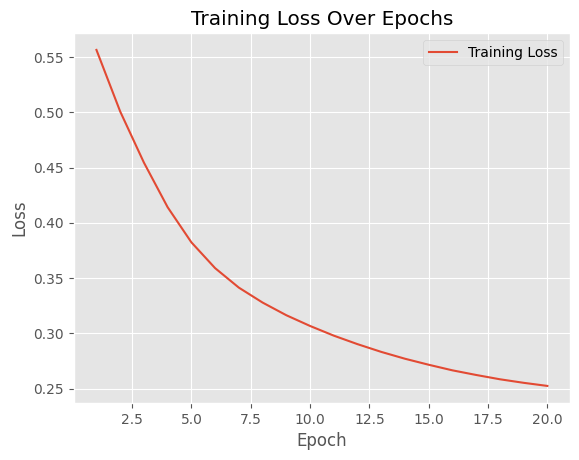

In [238]:
np.save("temp/autoencoder_conv_losses",autoencoder_losses_conv)
Display().plot_loss(autoencoder_losses_conv)

<Figure size 1000x500 with 0 Axes>

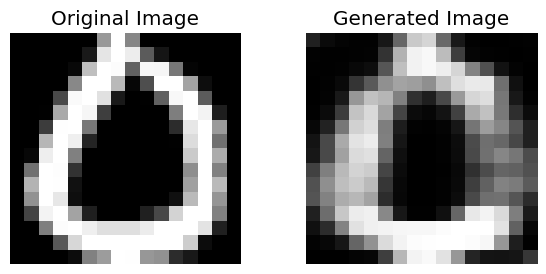

In [216]:
Display().plot_reconstruction(autoencoder_conv, X_test, y_test, expand_dims=True, n=1)

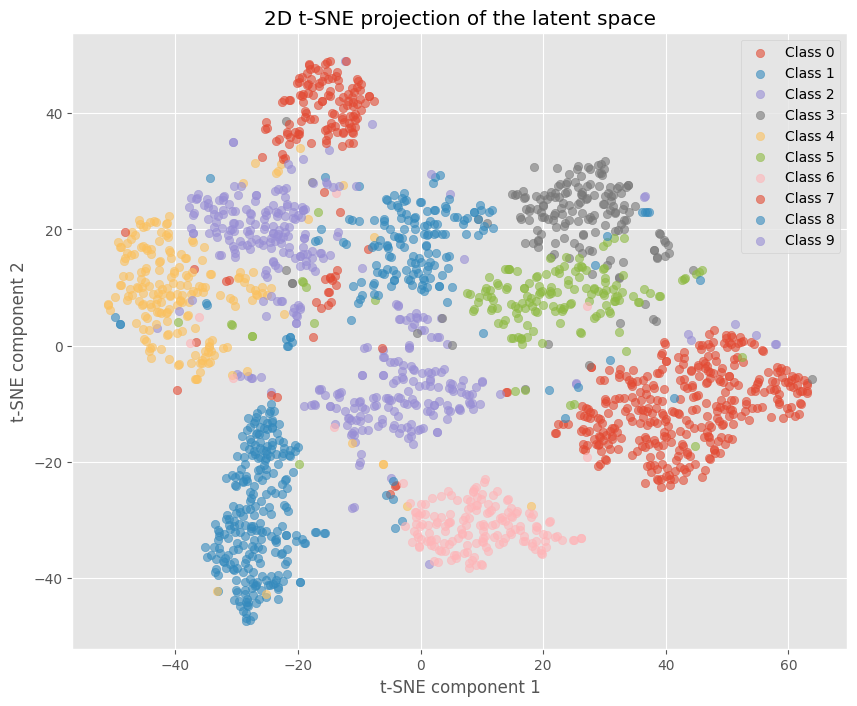

In [296]:
latent_space_conv = Display().plot_latent_space(X_test, y_test, encoder_conv, expand_dims=True)

## Comparaison
- L'ARI est supérieur sur les clusters crée sur l'espace latent obtenus a partir des convolutions

In [281]:
fn.cluster_kmeans(latent_space_conv, y_test)
fn.cluster_kmeans(latent_space_lin, y_test)

np.save("temp/latent_space_conv",latent_space_conv)
np.save("temp/latent_space_lin",latent_space_lin)

Adjusted Rand Index: 0.6724
Adjusted Rand Index: 0.5158


In [321]:
X_train_latent_conv = encoder_conv.forward(np.expand_dims(X_train, axis=-1))
X_test_latent_conv = encoder_conv.forward(np.expand_dims(X_test, axis=-1))
X_train_latent_lin = encoder_linear.forward(X_train)
X_test_latent_lin = encoder_linear.forward(X_test)

In [323]:
X_train_latent_conv = np.reshape(X_train_latent_conv, (X_train_latent_conv.shape[0], -1))
X_test_latent_conv = np.reshape(X_test_latent_conv, (X_test_latent_conv.shape[0], -1))
print("X_train_latent_conv shape: ", X_train_latent_conv.shape)
print("X_train_latent_lin shape: ", X_train_latent_lin.shape)

X_train_latent_conv shape:  (7291, 1024)
X_train_latent_lin shape:  (7291, 10)


## Classification des données avec latent-space

- On constate que le latent space obtenu avec les convolutions est bien meilleur (après c'est normal il y'a 1024 valeurs)

In [272]:
def train_model(X,y):   

    y = fn.to_one_hot(y,10)
    model = Sequential()
    model.add_module(Linear(X.shape[-1],10))
    model.add_module(TanH())
    model.add_module(Linear(10,10))
    model.add_module(TanH())
    model.add_module(Linear(10,10))
    loss = CrossEntropyLoss()
    optimizer = Optim(model,loss,1e-3)
    model_losses = SGD(optimizer, X, y, batch_size=64,epochs=250,verbose=False)

    return model, model_losses

model_conv, model_losses_conv = train_model(X_train_latent_conv, y_train)
model_lin, model_losses_lin = train_model(X_train_latent_lin, y_train)

Training finished.
Training finished.


In [275]:
fn.print_accuracy(model_conv, X_test_latent_conv, y_test)
fn.print_accuracy(model_lin, X_test_latent_lin, y_test)
print("Model conv losses: ", model_losses_conv[-1])
print("Model lin losses: ", model_losses_lin[-1])

Accuracy = 0.9257598405580468
Accuracy = 0.8719481813652217
Model conv losses:  0.004283970274226872
Model lin losses:  0.25428175194769104


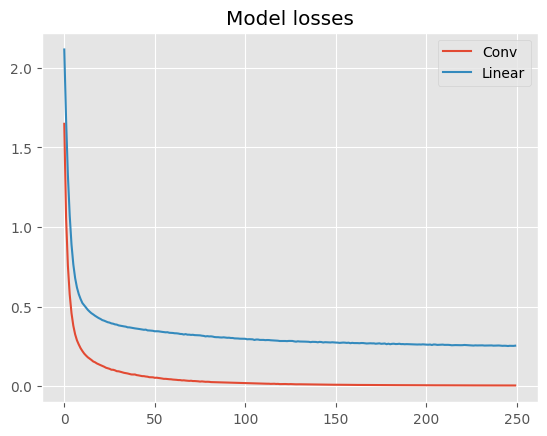

In [276]:
plt.figure()
plt.plot(model_losses_conv)
plt.plot(model_losses_lin)
plt.legend(["Conv","Linear"])
plt.title("Model losses")
plt.show()

## Variante de la taille du latent space
- Et si nous matchons la même taille avec un lineaire, c'est pareil au niveau des performances ?

In [297]:
autoencoder_linear_inv = Sequential()
encoder_linear_inv = Sequential()
decoder_linear_inv = Sequential()

encoder_linear_inv.add_module(Linear(256,512))
encoder_linear_inv.add_module(TanH())
encoder_linear_inv.add_module(Linear(512,1024))
encoder_linear_inv.add_module(TanH())
decoder_linear_inv.add_module(Linear(1024,512))
decoder_linear_inv.add_module(TanH())
decoder_linear_inv.add_module(Linear(512,256))
decoder_linear_inv.add_module(Sigmoid())

autoencoder_linear_inv.add_module(encoder_linear_inv)
autoencoder_linear_inv.add_module(decoder_linear_inv)

loss = BCELoss()
optimizer_autoencoder = Optim(autoencoder_linear_inv,loss,1e-3)
autoencoder_losses = SGD(optimizer_autoencoder,X_train, X_train, batch_size=64,epochs=250,verbose=True)

Epoch 1/250, Average Loss: 0.5040428604738565
Epoch 26/250, Average Loss: 0.2145634233012437
Epoch 51/250, Average Loss: 0.18434008223118092
Epoch 76/250, Average Loss: 0.17149919106618955
Epoch 101/250, Average Loss: 0.16451459775623595
Epoch 126/250, Average Loss: 0.15984108225527568
Epoch 151/250, Average Loss: 0.156448127189977
Epoch 176/250, Average Loss: 0.1539571610846463
Epoch 201/250, Average Loss: 0.1519801142691142
Epoch 226/250, Average Loss: 0.15053794729156558
Training finished.


<Figure size 1000x500 with 0 Axes>

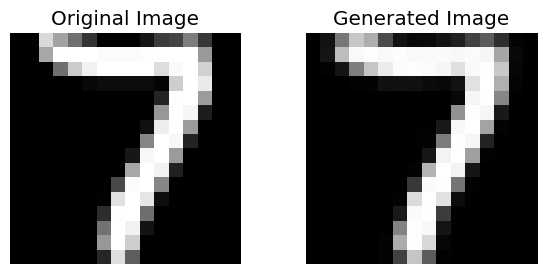

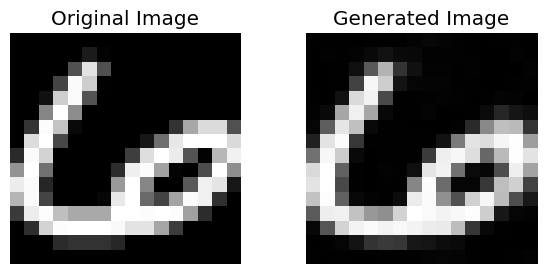

In [308]:
Display().plot_reconstruction(autoencoder_linear_inv, X_test, y_test, n=2)

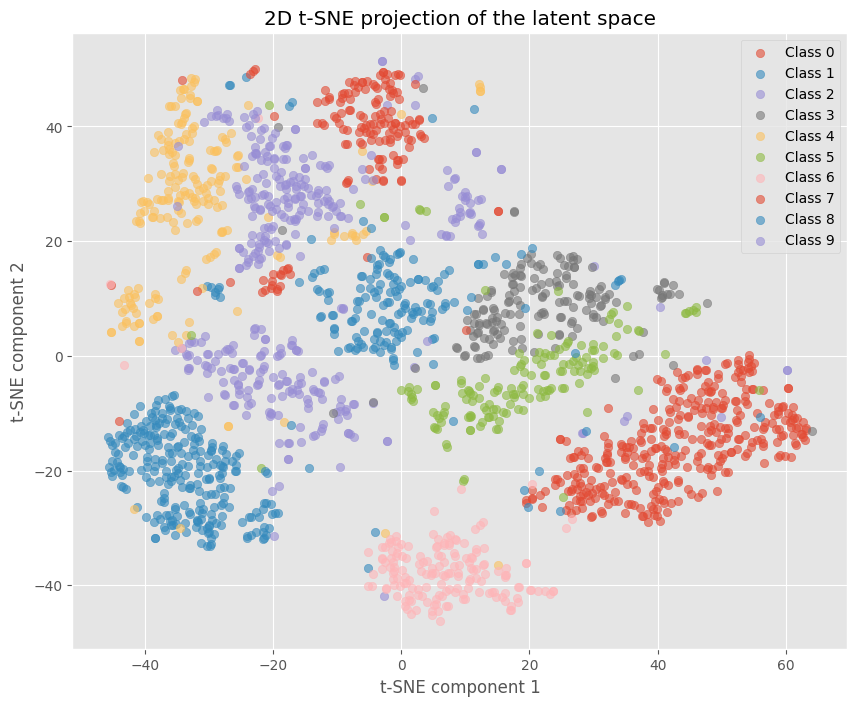

Adjusted Rand Index: 0.5496


In [309]:
latent_space_lin_inv = Display().plot_latent_space(X_test, y_test, encoder_linear_inv)
fn.cluster_kmeans(latent_space_lin_inv, y_test)
np.save("temp/latent_space_lin_inv",latent_space_lin)

In [310]:
X_train_latent_lin_inv = encoder_linear_inv.forward(X_train)
X_test_latent_lin_inv = encoder_linear_inv.forward(X_test)

model_lin_inv, model_losses_lin_inv = train_model(X_train_latent_lin_inv, y_train)

Training finished.


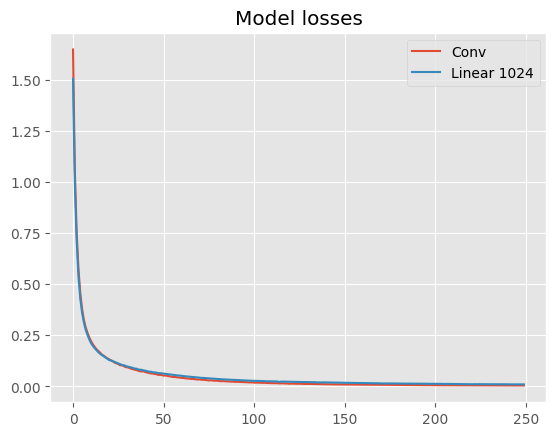

In [315]:
plt.figure()
plt.plot(model_losses_conv)
plt.plot(model_losses_lin_inv)
plt.legend(["Conv","Linear 1024"])
plt.title("Model losses")
plt.show()

In [316]:
fn.print_accuracy(model_lin_inv, X_test_latent_lin_inv, y_test)
print("Model lin losses: ", model_losses_lin_inv[-1])

Accuracy = 0.9162929745889388
Model lin losses:  0.00956088953007035


## T-test pour voir si y'a bien une différence entre les deux

Différence significative entre les loss, et accuracy

- Mean loss conv:  0.004266478439559869
- Mean loss inv:  0.009530081017576601
- Mean acc conv:  0.9260587942202292
- Mean acc inv:  0.9090682610861984
- T-test loss:  TtestResult(statistic=-16.726988712719947, pvalue=4.363641187061356e-08, df=9)
- T-test acc:  TtestResult(statistic=7.309194194389724, pvalue=4.519935070892253e-05, df=9)

In [326]:
from scipy import stats

def t_test(nb_train=5):
    loss_conv, loss_inv = [], []
    acc_conv, acc_inv = [], []
    for i in range(nb_train):
        print("Train: ", i)
        model_lin_inv_temp, model_losses_lin_inv_temp = train_model(X_train_latent_lin_inv, y_train)
        model_conv_temp, model_losses_conv_temp = train_model(X_train_latent_conv, y_train)
        acc_inv.append(fn.print_accuracy(model_lin_inv_temp, X_test_latent_lin_inv, y_test, print_result=False))
        acc_conv.append(fn.print_accuracy(model_conv_temp, X_test_latent_conv, y_test, print_result=False))
        loss_inv.append(model_losses_lin_inv_temp[-1])
        loss_conv.append(model_losses_conv_temp[-1])
    print("Mean loss conv: ", np.mean(loss_conv))
    print("Mean loss inv: ", np.mean(loss_inv))
    print("Mean acc conv: ", np.mean(acc_conv))
    print("Mean acc inv: ", np.mean(acc_inv))
    print("T-test loss: ", stats.ttest_rel(loss_conv, loss_inv))
    print("T-test acc: ", stats.ttest_rel(acc_conv, acc_inv))

    return loss_conv, loss_inv, acc_conv, acc_inv

loss_conv, loss_inv, acc_conv, acc_inv = t_test(10)

Training finished.
Training finished.
Mean loss conv:  0.004266478439559869
Mean loss inv:  0.009530081017576601
Mean acc conv:  0.9260587942202292
Mean acc inv:  0.9090682610861984
T-test loss:  TtestResult(statistic=-16.726988712719947, pvalue=4.363641187061356e-08, df=9)
T-test acc:  TtestResult(statistic=7.309194194389724, pvalue=4.519935070892253e-05, df=9)


In [327]:
np.save("temp/loss_conv",loss_conv)
np.save("temp/loss_inv",loss_inv)
np.save("temp/acc_conv",acc_conv)
np.save("temp/acc_inv",acc_inv)